# Import files, libraries, define path and initialize lists

In [ ]:
!pip install kagglehub
from google.colab import files

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [00:15<00:00, 187MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import glob
import os
import shutil
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

Mounted at /content/drive


In [ ]:
# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

In [ ]:
# Initialize lists
image_paths = []
species_labels = []
disease_labels = []
dataset_split = []

# Function to process a dataset directory
def process_directory(base_path, split_name):
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            species, disease = class_folder.split('___')
            for image_name in os.listdir(class_folder_path):
                image_paths.append(os.path.join(class_folder_path, image_name))
                species_labels.append(species)
                disease_labels.append(disease)
                dataset_split.append(split_name)

# Process train and valid
process_directory(train_path, 'train')
process_directory(valid_path, 'valid')

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'species': species_labels,
    'disease': disease_labels,
    'split': dataset_split
})

# Model Training

Model architecture inspection

In [ ]:

from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top layer
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Print the layers of the model
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │          19,494 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,273,844 (46.82 MB)

 Trainable params: 4,079,910 (15.56 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 8,159,822 (31.13 MB)

<ipython-input-14-c363ee1c1ece>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))


0 input_layer_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_rel

Last Block unfrozen

In [ ]:
for layer in base_model.layers[143:]:  # Unfreeze layers starting from index 143
    layer.trainable = True

# Optionally, print the layers to confirm
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [ ]:
import keras
keras.backend.clear_session()

#Define model name
Model_name = 'LLC_MobileNetV2_1Block_unfrozen_v1'

# Define the image generators for the training and validation set
batch_size = 32
num_classes = 38
img_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

# Import the MobileNetV2 model as a baseline
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (256, 256, 3))

#Unfreezing the last block
for layer in base_model.layers[143:]:  # Unfreeze layers starting from index 143
    layer.trainable = True

# Optionally, print the layers to confirm
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# Add custom layers for classification
model_mbn = Sequential()
model_mbn.add(base_model)
model_mbn.add(GlobalAveragePooling2D())
model_mbn.add(Dense(1024, activation = "relu"))
model_mbn.add(Dropout(rate = 0.2))
model_mbn.add(Dense(512, activation = "relu"))
model_mbn.add(Dropout(rate = 0.2))
model_mbn.add(Dense(num_classes, activation = "softmax"))

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model_mbn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Define callbacks
epoch_checkpoint = ModelCheckpoint(
    'model_epoch_{epoch:02d}.keras',  # Filename to save the model, it will save with the epoch number
    save_weights_only=False,       # Save the entire model (including architecture, optimizer, and weights)
    save_freq='epoch',             # Save the model after every epoch
    verbose=1                      # Print a message when saving the model
)
best_model = ModelCheckpoint(
    f"{Model_name}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [
    epoch_checkpoint,
    best_model
]

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


<ipython-input-15-923f620e3cfa>:31: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (256, 256, 3))


0 input_layer
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu


In [ ]:
# Training the model
model_mbn.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = callbacks
    )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8078 - loss: 0.6909
Epoch 1: saving model to model_epoch_01.keras

Epoch 1: val_accuracy improved from -inf to 0.51588, saving model to LLC_MobileNetV2_1Block_unfrozen_v1.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 196s 71ms/step - accuracy: 0.8079 - loss: 0.6907 - val_accuracy: 0.5159 - val_loss: 2.8516
Epoch 2/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9410 - loss: 0.2100
Epoch 2: saving model to model_epoch_02.keras

Epoch 2: val_accuracy did not improve from 0.51588
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 129s 58ms/step - accuracy: 0.9411 - loss: 0.2100 - val_accuracy: 0.4369 - val_loss: 4.0223
Epoch 3/50
2196/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9571 - loss: 0.1528
Epoch 3: saving model to model_epoch_03.keras

Epoch 3: val_accuracy did not improve from 0.51588
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 134s 61ms/step - accuracy: 0.9571 - loss: 0.1528 - val_accuracy: 0.3659 - val_loss: 6.0750
Epoch 4/50
2197/2197 ━━━━

Save model

In [ ]:
#Save model from Colab to GDrive
import shutil

# Define paths
source_model_path = '/content/LLC_MobileNetV2_1Block_unfrozen_v1.keras'  # Path to the model in Colab
destination_model_path = '/content/drive/MyDrive/DS_Models/LLC_MobileNetV2_1Block_unfrozen_v1.keras'  # Path to save in Google Drive

# Move the model to Google Drive
shutil.move(source_model_path, destination_model_path)

# Verify by listing the files in the destination directory
import os
print(os.listdir('/content/drive/MyDrive/DS_Models/'))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DS_Models/LLC_MobileNetV2_1Block_unfrozen_v1.keras'

In [ ]:
save_dir = "/content/drive/MyDrive/DS_models"
model_mbn.save(f"{save_dir}/LLC_MobileNetV2_unfrozen_v1.keras")

Plot metrics

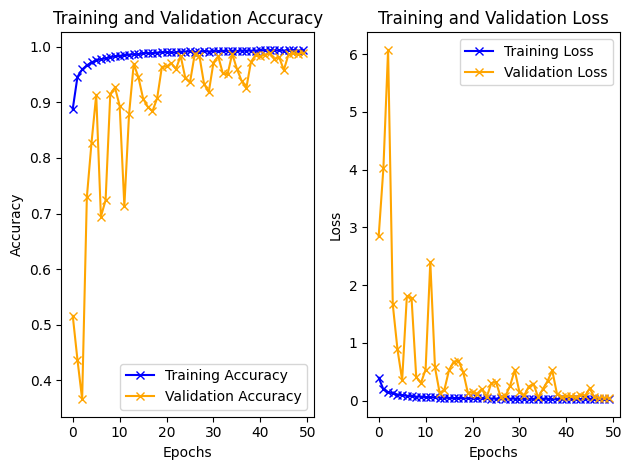

In [ ]:
mbn_history = model_mbn.history

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(mbn_history.history['accuracy'], label='Training Accuracy', color='blue', marker='x')
plt.plot(mbn_history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(mbn_history.history['loss'], label='Training Loss', color='blue', marker='x')
plt.plot(mbn_history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
import keras
keras.backend.clear_session()

from tensorflow.keras.models import load_model
from google.colab import drive


# load model
save_dir = "/content/drive/MyDrive/DS_models"
Model_name = "MobileNetV2_1Block_unfrozen_lr_E-3"
model_path = f"{save_dir}/{Model_name}.keras"

# Load the model
model_mbn = load_model(model_path)

Prediction and classification report

In [ ]:
# Generate predictions for validation set
val_pred = model_mbn.predict(validation_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = validation_generator.classes

# Classification report
class_report = classification_report(true_classes, val_pred_classes)
print("Classification Report:\n", class_report)

550/550 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.03      0.03       504
           1       0.03      0.03      0.03       497
           2       0.03      0.03      0.03       440
           3       0.04      0.04      0.04       502
           4       0.04      0.04      0.04       454
           5       0.02      0.02      0.02       421
           6       0.02      0.02      0.02       456
           7       0.02      0.01      0.01       410
           8       0.02      0.02      0.02       477
           9       0.02      0.02      0.02       477
          10       0.03      0.03      0.03       465
          11       0.03      0.03      0.03       472
          12       0.03      0.03      0.03       480
          13       0.04      0.04      0.04       430
          14       0.01      0.01      0.01       423
          15       0.02      0.02      0.02       503
          16  

In [ ]:
# Step 1: Evaluate the model on the validation set
loss, accuracy = model_mbn.evaluate(validation_generator)

# Step 2: Print the accuracy
print(f'Validation loss: {loss * 100:.2f}%')
print(f'Validation accuracy: {accuracy * 100:.2f}%')


550/550 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.9893 - loss: 0.0491
Validation loss: 4.91%
Validation accuracy: 98.97%


Evaluate the test folder

In [ ]:
# Define helper function to preprocess a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img) / 255.0               # Convert to array and rescale
    return img_array

# Load and preprocess all images from the test folder
def load_test_images(test_path, target_size):
    test_images = []
    filenames = []
    for file in os.listdir(test_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Supported file formats
            file_path = os.path.join(test_path, file)
            test_images.append(preprocess_image(file_path, target_size))
            filenames.append(file)  # Save filenames for reference
    return np.array(test_images), filenames

# Function to check if prediction is correct based on common words
def is_prediction_correct(file_name, predicted_label):
    # Extract meaningful words from file name (split camel case or concatenated words)
    file_name = re.sub(r'\.\w+$', '', file_name)  # Remove file extension
    file_words = set(word.lower() for word in re.findall(r'[A-Z][a-z]*|[a-z]+', file_name))  # Handle camel case and lowercase

    # Extract meaningful words from predicted label
    label_words = set(word.lower() for word in re.findall(r'[A-Za-z]+', predicted_label))  # Convert to lowercase

    # Check if all file words are in the label words
    is_subset = file_words.issubset(label_words)

    # Debugging output to verify
    #print(f"File Words: {file_words}, Label Words: {label_words}, Is Subset: {is_subset}")

    return is_subset

# Parameters
IMG_SIZE = (256, 256)  # Adjust to model's input size
test_path = test_path  # Define the test folder path

# Load and preprocess test images
test_images, filenames = load_test_images(test_path, target_size=IMG_SIZE)

# Make Predictions
predictions = model_mbn.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to class labels
class_labels = train_generator.class_indices
class_indices = {v: k for k, v in class_labels.items()}  # Reverse mapping of class indices
predicted_labels = [class_indices[idx] for idx in predicted_classes]

# Process and evaluate predictions
results = []

for file, pred, label in zip(filenames, predictions, predicted_labels):
    confidence = np.max(pred)  # Get the highest probability (confidence score)
    is_correct = is_prediction_correct(file, label)  # Check prediction correctness
    results.append({"True class": file, "prediction": label, "confidence": confidence, "Correct": int(is_correct)})
    print(f"True class: {file}, Prediction: {label}, Confidence: {confidence:.2f}, Correct: {is_correct}")

# Summary of results
correct_predictions = sum(result['Correct'] for result in results)
total_predictions = len(results)
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Total Predictions: {total_predictions}, Correct: {correct_predictions}, Accuracy: {accuracy:.2%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
True class: TomatoYellowCurlVirus2.JPG, Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Confidence: 1.00, Correct: True
True class: TomatoYellowCurlVirus3.JPG, Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Confidence: 1.00, Correct: True
True class: TomatoEarlyBlight3.JPG, Prediction: Tomato___Target_Spot, Confidence: 0.32, Correct: False
True class: TomatoEarlyBlight1.JPG, Prediction: Tomato___Early_blight, Confidence: 0.99, Correct: True
True class: AppleCedarRust3.JPG, Prediction: Apple___Cedar_apple_rust, Confidence: 1.00, Correct: True
True class: TomatoEarlyBlight2.JPG, Prediction: Tomato___Early_blight, Confidence: 0.95, Correct: True
True class: TomatoYellowCurlVirus6.JPG, Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Confidence: 1.00, Correct: True
True class: PotatoHealthy2.JPG, Prediction: Potato___healthy, Confidence: 1.00, Correct: True
True class: AppleCedarRust2.JPG, Prediction: Apple___Cedar_apple_rust, Confidence: 1.0